# Frame the Problem

1. **What is the objective?**  
   To understand and quantify the causal relationship between air quality and health outcomes. It is well established that deteriorating air quality can exacerbate conditions such as asthma and heart disease. For point-in-time events (e.g., forest fires, storms) that cause rapid declines in air quality, can we quantify their causal impact on health outcomes? For example, how many incremental emergency room visits for asthma attacks or heart attacks can be causally linked to the LA fires of early 2025?

2. **How will the solution be used?**  
   For now, this will be a standalone data analysis. In theory, cities could use insights from such an analysis to better prepare for spikes in emergency room visits during and after air quality events like fires or storms. Additionally, as the frequency and severity of these events increase due to climate change, this analysis could help forecast the public health costs of inaction on climate issues.

3. **What are current solutions?**  
   A brief search reveals a few similar analyses using machine learning to predict hospital visit volumes based on environmental data such as air quality:

   - [**Predictive Analytics for Emergency Department Visits Based on Local Short-Term Pollution and Weather Exposure**](https://www.researchgate.net/publication/379227522_Predictive_analytics_for_Emergency_Department_visits_based_on_local_short-term_pollution_and_weather_exposure):  
     This study applies machine learning techniques to forecast daily emergency department (ED) visits and hospitalizations for cardiovascular and respiratory conditions in Brescia, Italy (2018–2022). The researchers used Random Forest and ARIMA models, incorporating local air pollution and weather data. They found that the Random Forest model more accurately captured overall trends compared to ARIMA. The findings suggest that integrating environmental data with machine learning can improve ED resource planning and patient care during environmental events.

   - [**Peak Outpatient and Emergency Department Visit Forecasting for Patients With Chronic Respiratory Diseases Using Machine Learning Methods: Retrospective Cohort Study**](https://medinform.jmir.org/2020/3/e13075/?utm_source=chatgpt.com):  
     This retrospective study evaluates machine learning models for predicting peak outpatient and emergency department (OED) visits among patients with chronic respiratory diseases. The models combined air quality and weather data, using methods such as adaptive boosting-based neural networks, tree bagging, and random forests. The Random Forest model achieved the highest performance, with an AUC of 0.809. The study concludes that such models can effectively anticipate patient surges, aiding in proactive medical resource allocation.

4. **How should the problem be framed?**  
   This is primarily a regression task, using ML methods to predict continuous outcomes. The causal analysis is an extension of this task. I plan to use a geo experiment or matched-market framework to estimate causal impact via a counterfactual approach. The accuracy of the causal estimates hinges on the quality of the counterfactual.

5. **How should performance be measured?**  
   In geo experiments, performance is typically evaluated using Minimum Detectable Effect (MDE) and statistical power:

   - **MDE:** The smallest effect size the experiment can reliably detect. A smaller MDE implies greater sensitivity, enabling the detection of subtle effects. It is influenced by factors like KPI variability, the number of geographic units, and experiment duration.
   - **Power:** The probability of detecting a true effect when one exists. A standard threshold is 80%, meaning there is an 80% chance of identifying a real effect. Higher power reduces the risk of Type II errors.

6. **What are comparable problems?**  
   As mentioned, geo experiments are commonly used in marketing to estimate the incremental effect of ad spend on downstream outcomes (e.g., sales). While at Pinterest, I frequently analyzed geo experiment data. Several third-party vendors (e.g., Measured, Nielsen) offer geo experiment platforms, and companies like Google and Meta have released open-source tools—`matched_markets` and `GeoLift`, respectively.

7. **Have any assumptions been made?**  
   Yes. The analysis assumes that data on environmental factors (e.g., air quality, forest fires, storms) and health outcomes (e.g., hospital visits) is readily accessible. It also assumes that the geo experiment framework is applicable to this type of data.


# Get the Data

**What data is needed?**

This analysis requires several types of data:

1. **Environmental factors** — including temperature, humidity, air quality, and related metrics.
   - I will use the EPA Air Quality System (AQS) to obtain this data. The AQS provides daily summary data on pollutants and meteorological conditions. This data is available through [pre-generated data files](https://aqs.epa.gov/aqsweb/airdata/download_files.html) and a [REST API](https://aqs.epa.gov/aqsweb/documents/data_api.html). I will use the API, as it offers more flexibility and supports reproducible workflows.
2. **Health outcomes** — specifically hospital visits, with detailed information on the reasons for each visit.

Ideally, the data should be as granular as possible—preferably at the daily level—since geo experiments rely on time series data.


## Environmental data: air quality

In [1]:
# Get API key

import requests
from dotenv import load_dotenv
import os 

load_dotenv()

email = os.getenv("EMAIL")
url = "https://aqs.epa.gov/data/api/signup"
params = {
    "email": email
}

# response = requests.get(url, params=params)

# if response.status_code == 200:
#     print("Successfully signed up for the EPA AQS API.")
# else:   
#     print(f"Failed to sign up for the EPA AQS API. Status code: {response.status_code}")
#     print("Response:", response.text)

api_key = os.getenv("API_KEY")

In [2]:
# Parameter classes

import pandas as pd

url = "https://aqs.epa.gov/data/api/list/classes"
params = {
    "email": email, 
    "key": api_key
}

def get_aqs_data(url, params):
    response = requests.get(url, params=params)
    if response.status_code == 200:
        print("Successfully got data.")
        data = response.json()
        if data["Data"]:
            df = pd.DataFrame(data["Data"])
            return df
        else:
            print("No data returned for given parameters.")
    else:
        print(f"Failed to get data. Status code: {response.status_code}")
        print("Response:", response.text)

parameter_classes = get_aqs_data(url, params)
parameter_classes

Successfully got data.


,code,value_represented
0,AIRNOW MAPS,The parameters represented on AirNow maps (881...
1,ALL,Select all Parameters Available
2,AQI POLLUTANTS,Pollutants that have an AQI Defined
3,CORE_HAPS,Urban Air Toxic Pollutants
4,CRITERIA,Criteria Pollutants
5,CSN DART,List of CSN speciation parameters to populate ...
6,FORECAST,Parameters routinely extracted by AirNow (STI)
7,HAPS,Hazardous Air Pollutants
8,IMPROVE CARBON,IMPROVE Carbon Parameters
9,IMPROVE_SPECIATION,PM2.5 Speciated Parameters Measured at IMPROVE...


In [3]:
# Parameters by class 

url = "https://aqs.epa.gov/data/api/list/parametersByClass"
params = {
    "email": email, 
    "key": api_key, 
    "pc": "AIRNOW MAPS"
}

parameters_by_class = get_aqs_data(url, params)
parameters_by_class

Successfully got data.


,code,value_represented
0,44201,Ozone
1,88101,PM2.5 - Local Conditions
2,88502,Acceptable PM2.5 AQI & Speciation Mass


In [4]:
# CBSAs 

url = "https://aqs.epa.gov/data/api/list/cbsas"
params = {
    "email": email, 
    "key": api_key, 
}

cbsa = get_aqs_data(url, params)
cbsa.head()

Successfully got data.


,code,value_represented
0,10020,"Abbeville, LA"
1,10100,"Aberdeen, SD"
2,10140,"Aberdeen, WA"
3,10180,"Abilene, TX"
4,10220,"Ada, OK"


In [5]:
# Test, get AQI data for a single CBSA 
# CBSA: New York-Newark-Jersey City, NY-NJ-PA (Code 35620)

url = "https://aqs.epa.gov/data/api/dailyData/byCBSA"
params = {
    "email": email, 
    "key": api_key, 
    "param": "88101", 
    "bdate": "20230101", 
    "edate": "20231231", 
    "cbsa": "35620"
}

ny_daily_pm25 = get_aqs_data(url, params)
ny_daily_pm25.info()

Successfully got data.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60287 entries, 0 to 60286
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state_code            60287 non-null  object 
 1   county_code           60287 non-null  object 
 2   site_number           60287 non-null  object 
 3   parameter_code        60287 non-null  object 
 4   poc                   60287 non-null  int64  
 5   latitude              60287 non-null  float64
 6   longitude             60287 non-null  float64
 7   datum                 60287 non-null  object 
 8   parameter             60287 non-null  object 
 9   sample_duration_code  60287 non-null  object 
 10  sample_duration       60287 non-null  object 
 11  pollutant_standard    55036 non-null  object 
 12  date_local            60287 non-null  object 
 13  units_of_measure      60287 non-null  object 
 14  event_type            60287 non-null  object 
 

In [6]:
# Explore raw data from NY CBSA 

# Sample sorted data 
ny_daily_pm25.sort_values(['date_local', 'site_number']).head(1000)

# Number of records per site
ny_daily_pm25.groupby(['date_local', 'site_number'])['aqi'].count().reset_index().sort_values(['date_local', 'site_number'])

# Number of sites 
ny_daily_pm25['site_number'].nunique()

# Aggregate so that each day has a single row --> simple arithmetic mean 
ny_daily_pm25.groupby(['date_local'])['aqi'].mean().reset_index().sort_values('date_local', ascending=True)

# Combine different aggregation techniques 

# More aggregation techniques: median 
ny_daily_pm25.groupby(['date_local'])['aqi'].median().reset_index().sort_values('date_local', ascending=True)

# More aggregation techniques: max 
ny_daily_pm25.groupby(['date_local'])['aqi'].max().reset_index().sort_values('date_local', ascending=True)

# Multiple aggregation techniques at once 
ny_daily_pm25.groupby(['date_local']).agg(mean_aqi=('aqi', 'mean'), median_aqi=('aqi', 'median'), max_aqi=('aqi', 'max'))

# Validity indicator 
ny_daily_pm25.groupby('validity_indicator')['aqi'].count()

validity_indicator
N        0
Y    55036
Name: aqi, dtype: int64

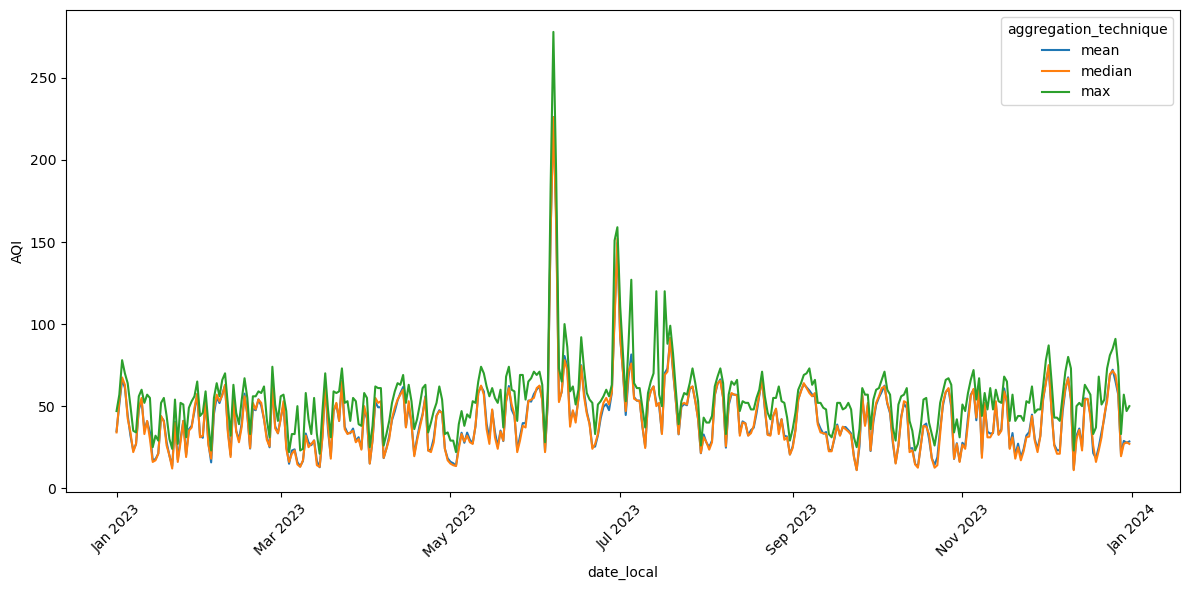

In [7]:
# Compare different aggregation methods for AQI 

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

agg_ny_daily_pm25 = ny_daily_pm25.groupby(['date_local']).agg(mean=('aqi', 'mean'), median=('aqi', 'median'), max=('aqi', 'max')).reset_index()
agg_ny_daily_pm25['date_local'] = pd.to_datetime(agg_ny_daily_pm25['date_local'], format='%Y-%m-%d')

# Convert to long format for Seaborn
agg_ny_daily_pm25 = agg_ny_daily_pm25.melt(id_vars='date_local', var_name='aggregation_technique', value_name='AQI')

plt.figure(figsize=(12, 6))
sns.lineplot(data=agg_ny_daily_pm25, x='date_local', y='AQI', hue='aggregation_technique')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # every 2 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., Jan 2024

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Determine how many years of data are available 
# There seems to be sufficient data going back to the start of 2020 through end of 2024 (error on 2025)

# Try to go back to 2020
url = "https://aqs.epa.gov/data/api/dailyData/byCBSA"
date_counts = {}

for year in ['2020', '2021', '2022', '2023', '2024']:
    params = {
        'email': email, 
        'key': api_key, 
        'param': '88101', 
        'bdate': f'{year}0101', 
        'edate': f'{year}1231', 
        'cbsa': '35620'
    }

    # Comment out for now, execution not needed 
    # df = get_aqs_data(url, params=params)
    # dates = df['date_local'].nunique()
    # rows = df.shape[0]

    # date_counts[year] = (dates, rows)
    
date_counts

{}

In [9]:
# Select top 20 CBSAs (population size) for analysis, make sure they exist in AQS data

cbsa['code'] = cbsa['code'].astype(int)

top_20_cbsa = pd.read_csv('data/top_20_cbsa.csv', header=0)
top_20_cbsa = list(top_20_cbsa['code'])

cbsa[cbsa['code'].isin(top_20_cbsa)].sort_values('value_represented')

,code,value_represented
53,12060,"Atlanta-Sandy Springs-Roswell, GA"
64,12580,"Baltimore-Columbia-Towson, MD"
113,14460,"Boston-Cambridge-Newton, MA-NH"
174,16980,"Chicago-Naperville-Elgin, IL-IN-WI"
228,19100,"Dallas-Fort Worth-Arlington, TX"
244,19740,"Denver-Aurora-Lakewood, CO"
247,19820,"Detroit-Warren-Dearborn, MI"
415,26420,"Houston-The Woodlands-Sugar Land, TX"
535,31080,"Los Angeles-Long Beach-Anaheim, CA"
590,33100,"Miami-Fort Lauderdale-West Palm Beach, FL"


In [10]:
# Test how many CBSAs can be queried at once 
# Seems that only one CBSA can be queried at once 

string_top_20_cbsa = [f'{cbsa}' for cbsa in top_20_cbsa]
url = 'https://aqs.epa.gov/data/api/dailyData/byCBSA'
params = {
    'email': email, 
    'key': api_key, 
    'param': '88101', 
    'bdate': f'20200101', 
    'edate': f'20201231', 
    'cbsa': string_top_20_cbsa
}
df = get_aqs_data(url, params=params)

Successfully got data.


In [11]:
# Get daily PM2.5 AQI data from top 20 CBSAs, 2020-2024

import time

url = 'https://aqs.epa.gov/data/api/dailyData/byCBSA'

daily_pm25_top_20_cbsa = pd.DataFrame()

for cbsa in top_20_cbsa:
    for year in ['2020', '2021', '2022', '2023', '2024']:
        params = {
            'email': email, 
            'key': api_key, 
            'param': '88101', 
            'bdate': f'{year}0101', 
            'edate': f'{year}1231', 
            'cbsa': cbsa
        }
        # print(cbsa, f'{year}0101', f'{year}1231')
        
        # df = get_aqs_data(url, params=params)
        # daily_pm25_top_20_cbsa = pd.concat([daily_pm25_top_20_cbsa, df])

        # time.sleep(1)

In [12]:
# Save data locally 

# daily_pm25_top_20_cbsa.to_parquet('data/daily_pm25_top_20_cbsa.parquet', index=False, engine='fastparquet')
daily_pm25_top_20_cbsa = pd.read_parquet('data/daily_pm25_top_20_cbsa.parquet', engine='fastparquet')

daily_pm25_top_20_cbsa.shape

(4169072, 32)

In [13]:
# Check daily dataset 

# How many CBSAs? 20
daily_pm25_top_20_cbsa['cbsa'].nunique()

# How much data for each CBSA? More than 50k rows for each CBSA, looks fine
daily_pm25_top_20_cbsa.groupby('cbsa')['aqi'].count()

# How many days of data for each CBSA? Each CBSA has full year of data, looks fine
daily_pm25_top_20_cbsa.groupby('cbsa')['date_local'].nunique()/5

cbsa
Atlanta-Sandy Springs-Roswell, GA               365.4
Baltimore-Columbia-Towson, MD                   365.2
Boston-Cambridge-Newton, MA-NH                  365.4
Chicago-Naperville-Elgin, IL-IN-WI              365.4
Dallas-Fort Worth-Arlington, TX                 365.4
Denver-Aurora-Lakewood, CO                      365.4
Detroit-Warren-Dearborn, MI                     365.4
Houston-The Woodlands-Sugar Land, TX            365.4
Los Angeles-Long Beach-Anaheim, CA              365.4
Miami-Fort Lauderdale-West Palm Beach, FL       365.4
Minneapolis-St. Paul-Bloomington, MN-WI         365.4
New York-Newark-Jersey City, NY-NJ-PA           365.4
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD     365.4
Phoenix-Mesa-Scottsdale, AZ                     365.4
Riverside-San Bernardino-Ontario, CA            365.4
San Diego-Carlsbad, CA                          365.4
San Francisco-Oakland-Hayward, CA               363.4
Seattle-Tacoma-Bellevue, WA                     365.4
Tampa-St. Petersburg-Cl

In [25]:
daily_pm25_top_20_cbsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4169072 entries, 0 to 4169071
Data columns (total 32 columns):
 #   Column                Dtype  
---  ------                -----  
 0   state_code            object 
 1   county_code           object 
 2   site_number           object 
 3   parameter_code        object 
 4   poc                   int64  
 5   latitude              float64
 6   longitude             float64
 7   datum                 object 
 8   parameter             object 
 9   sample_duration_code  object 
 10  sample_duration       object 
 11  pollutant_standard    object 
 12  date_local            object 
 13  units_of_measure      object 
 14  event_type            object 
 15  observation_count     int64  
 16  observation_percent   float64
 17  validity_indicator    object 
 18  arithmetic_mean       float64
 19  first_max_value       float64
 20  first_max_hour        int64  
 21  aqi                   float64
 22  method_code           object 
 23  method 

In [26]:
# Create daily CBSA-level daily dataset

final_pm25_daily = daily_pm25_top_20_cbsa.groupby(['cbsa', 'cbsa_code', 'date_local']).agg(aqi=('aqi', 'mean')).reset_index()
final_pm25_daily['date_local'] = pd.to_datetime(final_pm25_daily['date_local'], format='%Y-%m-%d')
final_pm25_daily['cbsa_code'] = final_pm25_daily['cbsa_code'].astype(int)
final_pm25_daily.head()

,cbsa,cbsa_code,date_local,aqi
0,"Atlanta-Sandy Springs-Roswell, GA",12060,2020-01-01,33.8
1,"Atlanta-Sandy Springs-Roswell, GA",12060,2020-01-02,53.2
2,"Atlanta-Sandy Springs-Roswell, GA",12060,2020-01-03,37.2
3,"Atlanta-Sandy Springs-Roswell, GA",12060,2020-01-04,20.4
4,"Atlanta-Sandy Springs-Roswell, GA",12060,2020-01-05,29.8


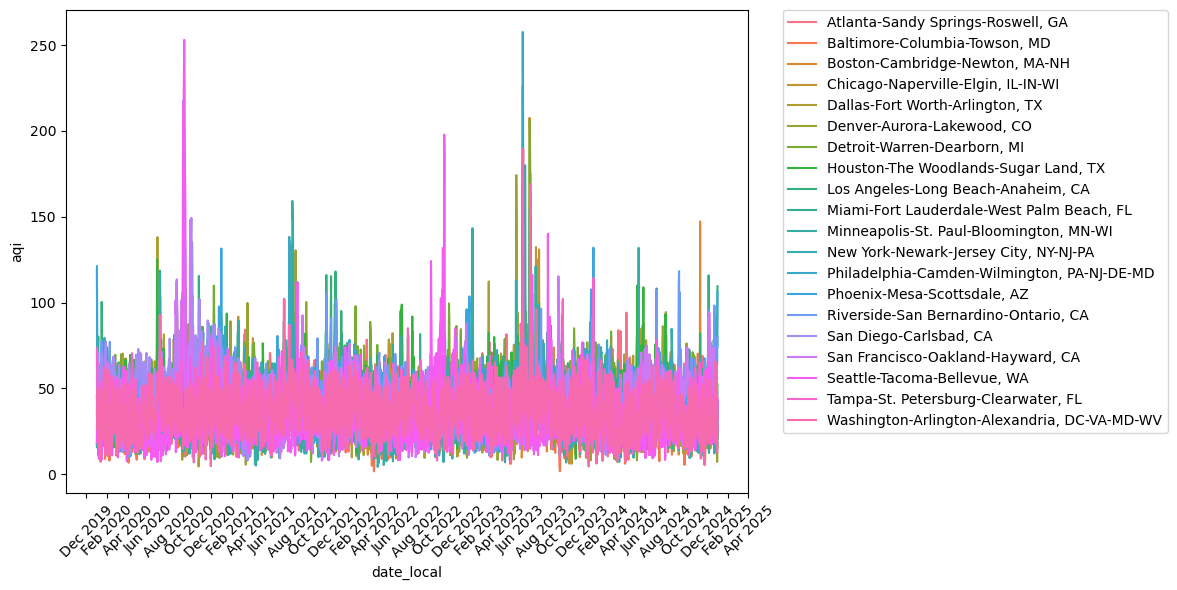

In [30]:
# Plot all 20 CBSA series 

plt.figure(figsize=(12, 6))
sns.lineplot(data=final_pm25_daily, x='date_local', y='aqi', hue='cbsa')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # every 1 month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., Jan 2024

plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

# EDA

## Environmental Data

We currently have a robust dataset for air quality: daily CBSA-level AQI measurements for PM2.5.

- **PM2.5** refers to fine particulate matter in the air that is 2.5 micrometers or smaller in diameter. These particles are small enough to be inhaled and penetrate deep into the lungs, posing significant health risks. PM2.5 is a major component of smog and is linked to various respiratory and cardiovascular problems.

Other environmental factors, such as daily meteorological conditions (e.g., temperature, humidity), may also be relevant. However, for the purpose of analyzing a geo experiment, AQI is the most critical variable. Additional factors might be considered for "market matching" or covariate adjustment.

In [31]:
# Make copy of data for exploration

eda_final_pm25_daily = final_pm25_daily.copy()

In [32]:
# Understand type/shape of data 

eda_final_pm25_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36526 entries, 0 to 36525
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   cbsa        36526 non-null  object        
 1   cbsa_code   36526 non-null  int64         
 2   date_local  36526 non-null  datetime64[ns]
 3   aqi         36516 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.1+ MB


In [42]:
# Understand 10 null values for mean_aqi
# Null values seem to be error in data, as other columns are populated for those days
# Only 10 total days (from 36K+ observations) across all 20 CBSAs with null AQI values, disregard for now 

import datetime

eda_final_pm25_daily[eda_final_pm25_daily['aqi'].isnull()].sort_values(['cbsa', 'date_local'])

daily_pm25_top_20_cbsa[(daily_pm25_top_20_cbsa['cbsa_code'] == '41860') & (daily_pm25_top_20_cbsa['aqi'].isnull())]

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
2648150,06,001,0015,88101,3,37.701222,-121.903019,NAD83,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,Pleasanton - Owens Ct,Owens Ct.,California,Alameda,Pleasanton,41860,"San Francisco-Oakland-Hayward, CA",2024-08-07
2648151,06,001,0015,88101,3,37.701222,-121.903019,NAD83,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,Pleasanton - Owens Ct,Owens Ct.,California,Alameda,Pleasanton,41860,"San Francisco-Oakland-Hayward, CA",2024-08-07
2648152,06,001,0015,88101,3,37.701222,-121.903019,NAD83,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,Pleasanton - Owens Ct,Owens Ct.,California,Alameda,Pleasanton,41860,"San Francisco-Oakland-Hayward, CA",2024-08-07
2648175,06,001,0015,88101,3,37.701222,-121.903019,NAD83,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,Pleasanton - Owens Ct,Owens Ct.,California,Alameda,Pleasanton,41860,"San Francisco-Oakland-Hayward, CA",2024-08-07
2648183,06,001,0015,88101,3,37.701222,-121.903019,NAD83,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,Pleasanton - Owens Ct,Owens Ct.,California,Alameda,Pleasanton,41860,"San Francisco-Oakland-Hayward, CA",2024-08-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2792261,06,013,1004,88101,3,37.960400,-122.356811,WGS84,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,San Pablo,"1865 D RUMRILL BLVD, San Pablo",California,Contra Costa,San Pablo,41860,"San Francisco-Oakland-Hayward, CA",2025-04-28
2792270,06,013,1004,88101,3,37.960400,-122.356811,WGS84,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,San Pablo,"1865 D RUMRILL BLVD, San Pablo",California,Contra Costa,San Pablo,41860,"San Francisco-Oakland-Hayward, CA",2025-04-28
2792279,06,013,1004,88101,3,37.960400,-122.356811,WGS84,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,San Pablo,"1865 D RUMRILL BLVD, San Pablo",California,Contra Costa,San Pablo,41860,"San Francisco-Oakland-Hayward, CA",2025-04-28
2792288,06,013,1004,88101,3,37.960400,-122.356811,WGS84,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,San Pablo,"1865 D RUMRILL BLVD, San Pablo",California,Contra Costa,San Pablo,41860,"San Francisco-Oakland-Hayward, CA",2025-04-28


In [ ]:
# See distributions 

eda_final_pm25_daily.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
cbsa_code,36526.0,30499.166073,12060.0,19100.0,33100.0,40140.0,47900.0,11512.34887
date_local,36526,2022-07-01 18:42:40.586979072,2020-01-01 00:00:00,2021-04-01 00:00:00,2022-07-02 00:00:00,2023-10-01 00:00:00,2024-12-31 00:00:00,NaN
aqi,36516.0,40.858397,1.75,29.0,39.875,51.486185,257.605263,16.20307


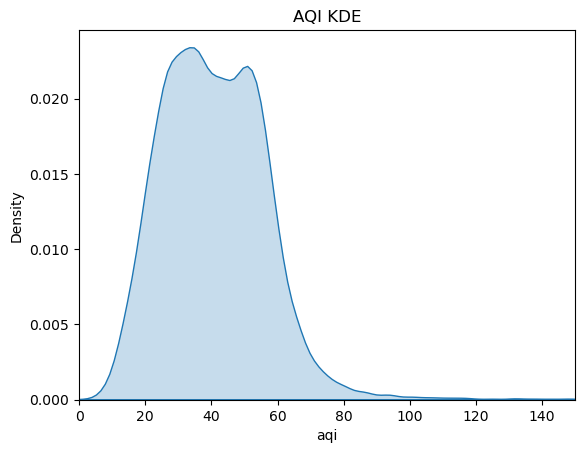

In [ ]:
# Plot distribution of AQI 
# Appears to have slight bimodal distribution centered around 30 and 60

sns.kdeplot(data=eda_final_pm25_daily, x='aqi', fill=True)
plt.title('AQI KDE')
plt.xlim(0, 150)
plt.show()

In [ ]:
cbsa_region_map = {
    35620: "Northeast",  # New York-Newark-Jersey City, NY-NJ-PA
    37980: "Northeast",  # Philadelphia-Camden-Wilmington, PA-NJ-DE-MD
    14460: "Northeast",  # Boston-Cambridge-Newton, MA-NH
    12580: "Northeast",  # Baltimore-Columbia-Towson, MD
    47900: "Northeast",  # Washington-Arlington-Alexandria, DC-VA-MD-WV

    12060: "Southeast",  # Atlanta-Sandy Springs-Alpharetta, GA
    33100: "Southeast",  # Miami-Fort Lauderdale-West Palm Beach, FL
    45300: "Southeast",  # Tampa-St. Petersburg-Clearwater, FL

    16980: "Midwest",    # Chicago-Naperville-Elgin, IL-IN-WI
    19820: "Midwest",    # Detroit-Warren-Dearborn, MI
    33460: "Midwest",    # Minneapolis-St. Paul-Bloomington, MN-WI

    19100: "South Central",  # Dallas-Fort Worth-Arlington, TX
    26420: "South Central",  # Houston-The Woodlands-Sugar Land, TX

    31080: "West",       # Los Angeles-Long Beach-Anaheim, CA
    41860: "West",       # San Francisco-Oakland-Berkeley, CA
    41740: "West",       # San Diego-Chula Vista-Carlsbad, CA
    40140: "West",       # Riverside-San Bernardino-Ontario, CA
    38060: "West",       # Phoenix-Mesa-Chandler, AZ
    19740: "West",       # Denver-Aurora-Lakewood, CO
    42660: "West"        # Seattle-Tacoma-Bellevue, WA
}

eda_final_pm25_daily['region'] = eda_final_pm25_daily['cbsa_code'].map(cbsa_region_map)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36526 entries, 0 to 36525
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   cbsa        36526 non-null  object        
 1   cbsa_code   36526 non-null  int64         
 2   date_local  36526 non-null  datetime64[ns]
 3   aqi         36516 non-null  float64       
 4   region      36526 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 1.4+ MB
